In [34]:
import datetime
import time

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import notebook_libs.utilities as util
import notebook_libs.prometheus as prom

## Experiment in Progress - Client Data

Updated 2023-02-17 13:51:47.768980
in-progress
count    19616.000000
mean       795.444206
std        279.970249
min        497.415066
25%        549.862802
50%        710.682511
75%        974.412739
max       2451.415062
Name: client_latency_ms, dtype: float64



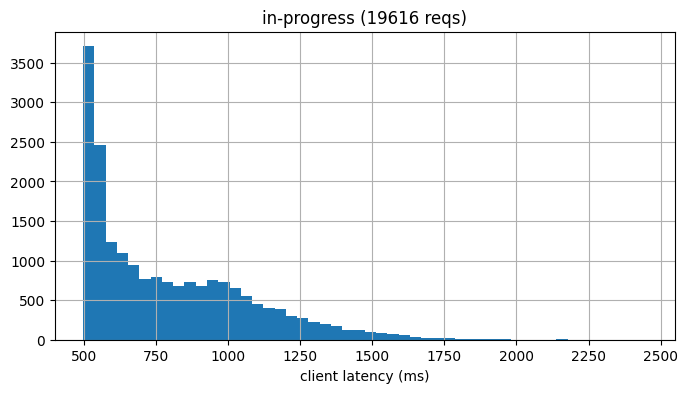

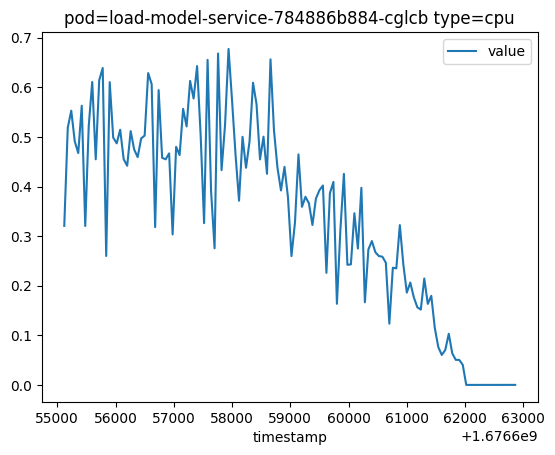

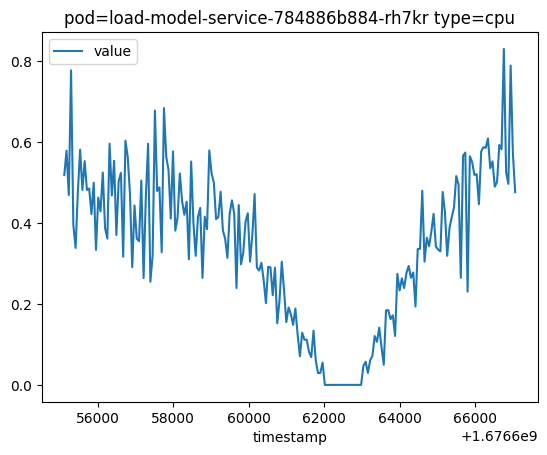

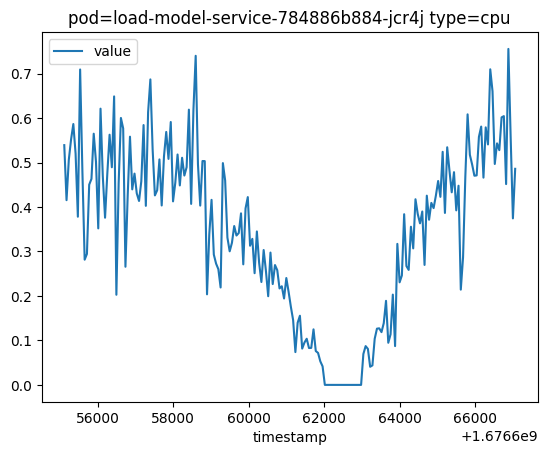

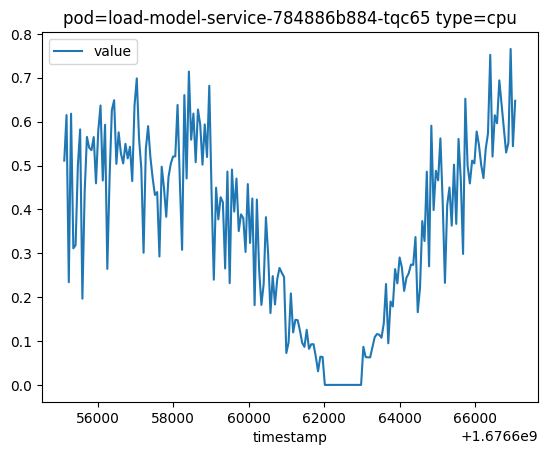

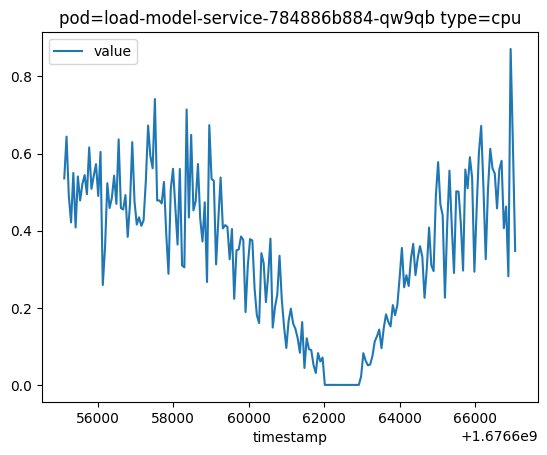

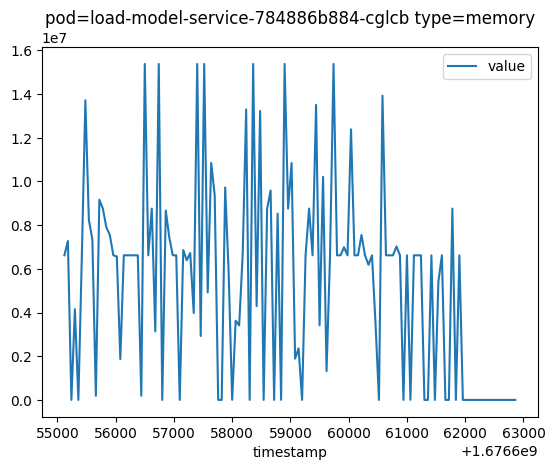

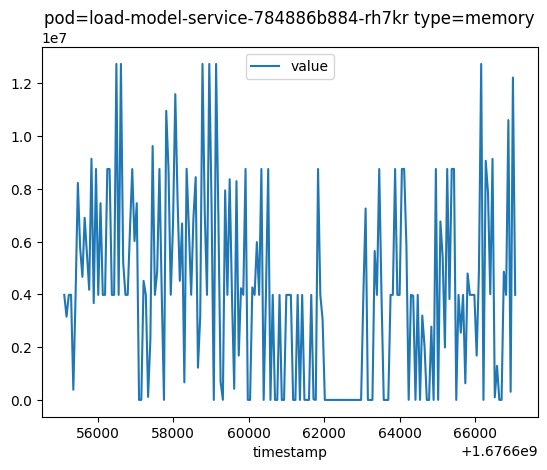

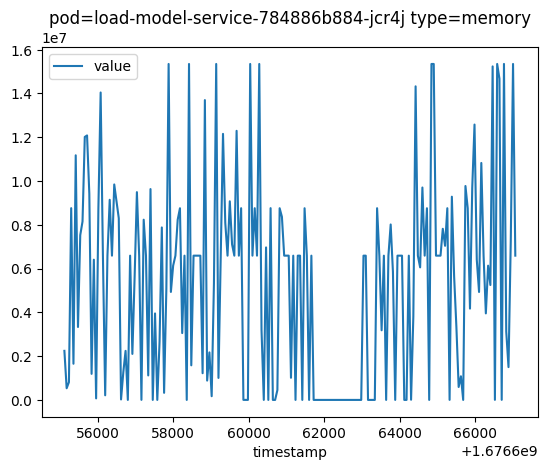

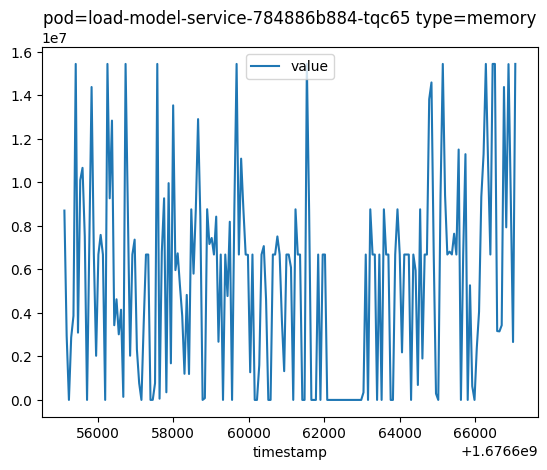

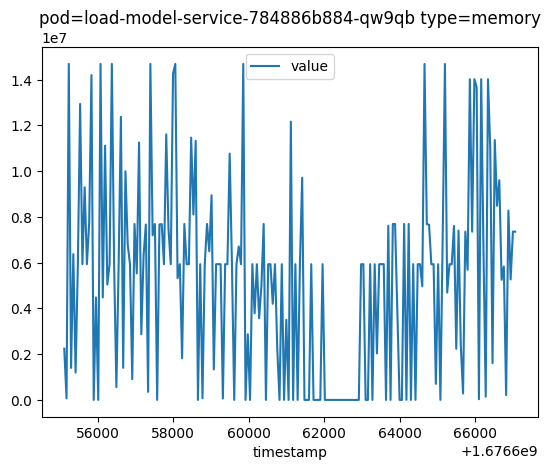

In [ ]:
while True:
    print(f"Updated {datetime.datetime.now()}")
    df = util.read_client_requests_in_progress()
    f, ax = plt.subplots(figsize=[8,4])
    util.plot_client_latency_distribution(df, "in-progress", ax)
    plt.show()
    result = prom.fetch_experiment_pod_data(int(12000/60.))
    util.plot_pod_metrics(result)
    plt.show()
    time.sleep(200)

## Experiment in Progress - Prometheus Data

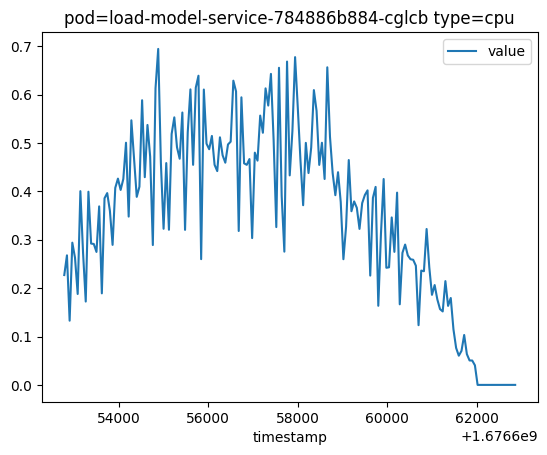

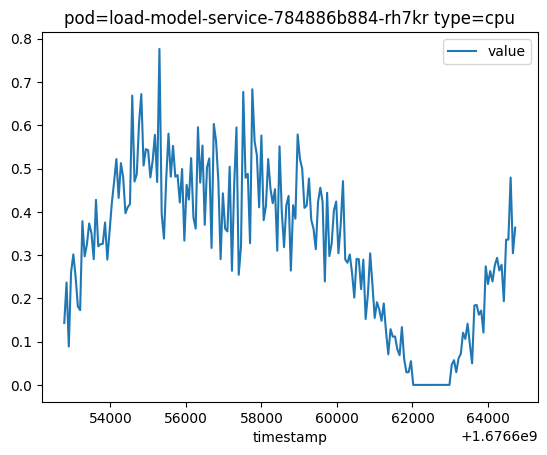

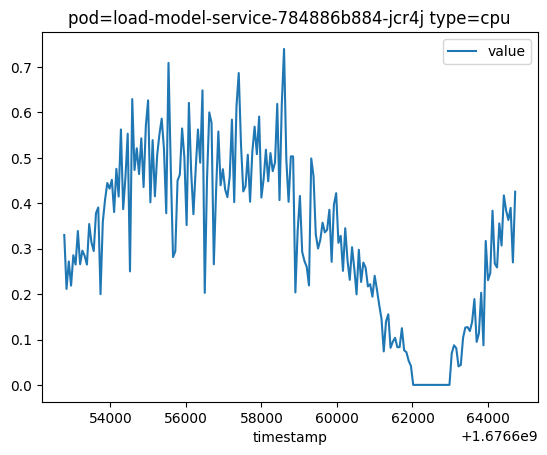

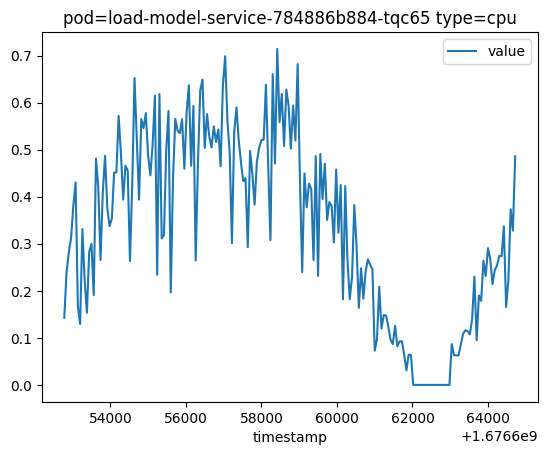

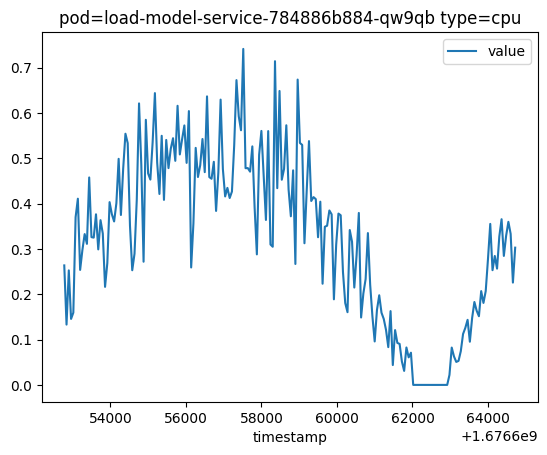

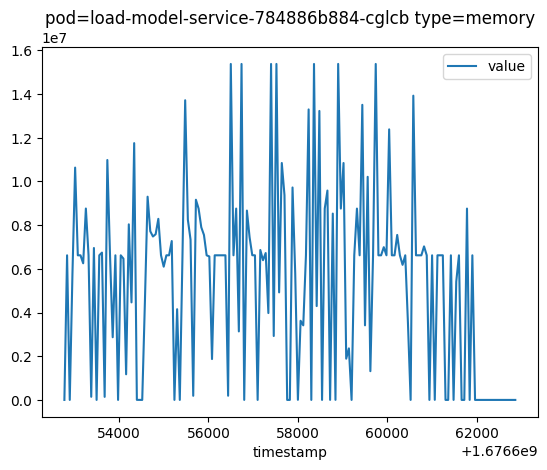

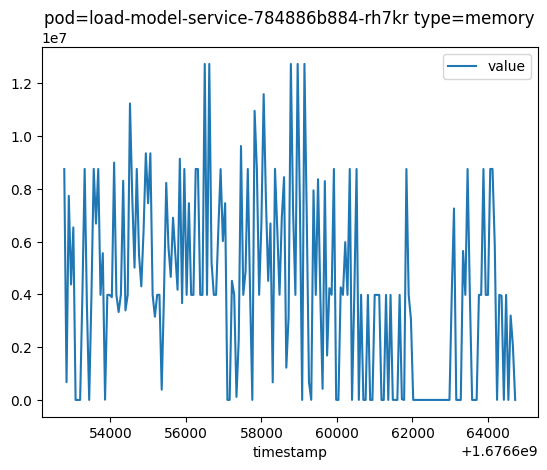

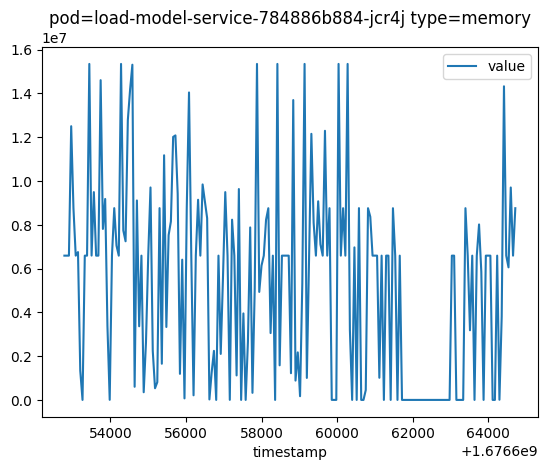

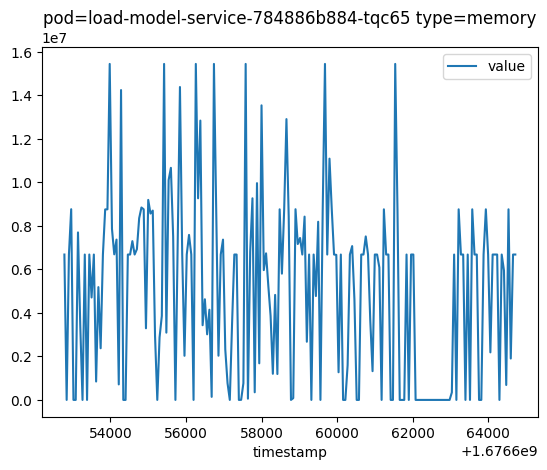

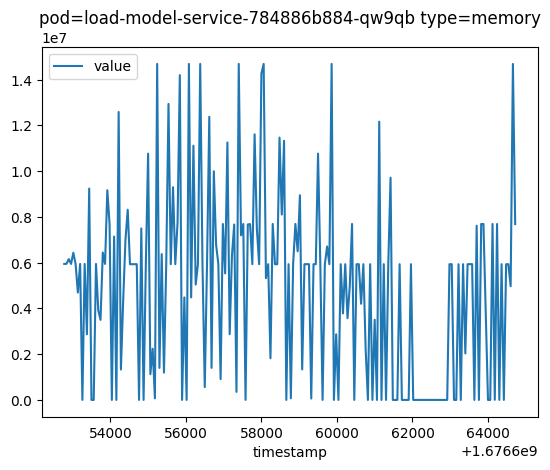

In [32]:
result = prom.fetch_experiment_pod_data(int(12000/60.))
util.plot_pod_metrics(result)

## Completed Experiment

In [25]:
current_experiment = "2023-02-17_5-replicas"

### Persist Data

In [5]:
# current_experiment
# util.persist_pod_dfs(result, current_experiment)
# util.persist_pod_dfs(result, "tmp")

### Create 1-Minute buckets for client request data

<AxesSubplot: title={'center': 'Client Metrics (1Min Buckets)'}, xlabel='bucket_1_min'>

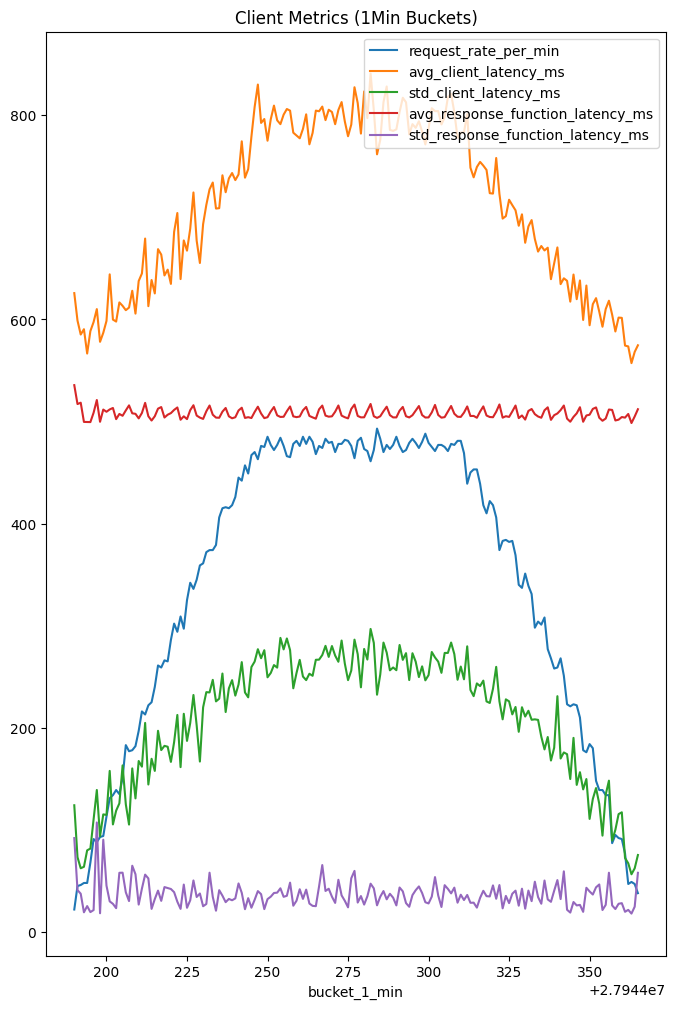

In [26]:
df, first_request_time, final_request_time = util.read_client_requests(current_experiment)
df_bucket = util.create_1_min_bucket_client_metrics(df)
df_bucket.plot(x='bucket_1_min', y=[
    "request_rate_per_min", 
    "avg_client_latency_ms",
    "std_client_latency_ms",
    "avg_response_function_latency_ms",
    "std_response_function_latency_ms"
]
,figsize=[8,12]
,title="Client Metrics (1Min Buckets)")

### Determine window boundaries

In [27]:
df_client, first_request_time, final_request_time = util.read_client_requests(current_experiment)
first_request_time = int(first_request_time)
final_request_time = int(final_request_time + 120)
print(first_request_time, final_request_time)

1676651434 1676662070


In [28]:
df_client.describe()

,client_latency_ms,response_start_time_sec,response_function_latency_ms,response_memory_request,response_memory_usage_mb,response_sleep_delay_ms,response_load_time_ms,response_load_request,response_load_calibration,bucket_1_min
count,59998.000000,5.999800e+04,59998.000000,59998.0,59998.000000,59998.0,59998.000000,59998.0,59998.0,5.999800e+04
mean,745.289115,1.676657e+09,507.744116,250.0,293.854689,200.0,21.041774,10.0,15000.0,2.794428e+07
std,247.546582,2.398350e+03,37.557616,0.0,0.133669,0.0,3.555629,0.0,0.0,3.997422e+01
min,495.505810,1.676651e+09,474.290609,250.0,293.718750,200.0,17.890930,10.0,15000.0,2.794419e+07
25%,542.471647,1.676655e+09,490.238965,250.0,293.773438,200.0,18.630981,10.0,15000.0,2.794425e+07
50%,652.411938,1.676657e+09,499.752998,250.0,293.785156,200.0,19.214511,10.0,15000.0,2.794428e+07
75%,897.298217,1.676659e+09,514.661729,250.0,293.902344,200.0,22.432268,10.0,15000.0,2.794431e+07
max,2374.262094,1.676662e+09,1818.006277,250.0,294.125000,200.0,140.145540,10.0,15000.0,2.794436e+07


## Compare a Group of Experiments

['2023-02-15_2-replicas', '2023-02-15_3-replicas', '2023-02-16_4-replicas', '2023-02-16_5-replicas', '2023-02-16_6-replicas']
2023-02-15_2-replicas
count    34997.000000
mean      1099.488524
std        407.907852
min        503.618002
25%        736.459970
50%       1054.556847
75%       1431.749821
max       3242.873907
Name: client_latency_ms, dtype: float64

2023-02-15_3-replicas
count    39998.000000
mean       823.151578
std        274.428795
min        504.801035
25%        566.181242
50%        725.034833
75%       1040.222645
max       2340.388775
Name: client_latency_ms, dtype: float64

2023-02-16_4-replicas
count    44998.000000
mean       728.320758
std        248.259402
min        500.531912
25%        539.703369
50%        606.315851
75%        963.607073
max       2469.373941
Name: client_latency_ms, dtype: float64

2023-02-16_5-replicas
count    50000.000000
mean       683.718426
std        220.561977
min        494.807005
25%        532.964766
50%        574.086428
75%

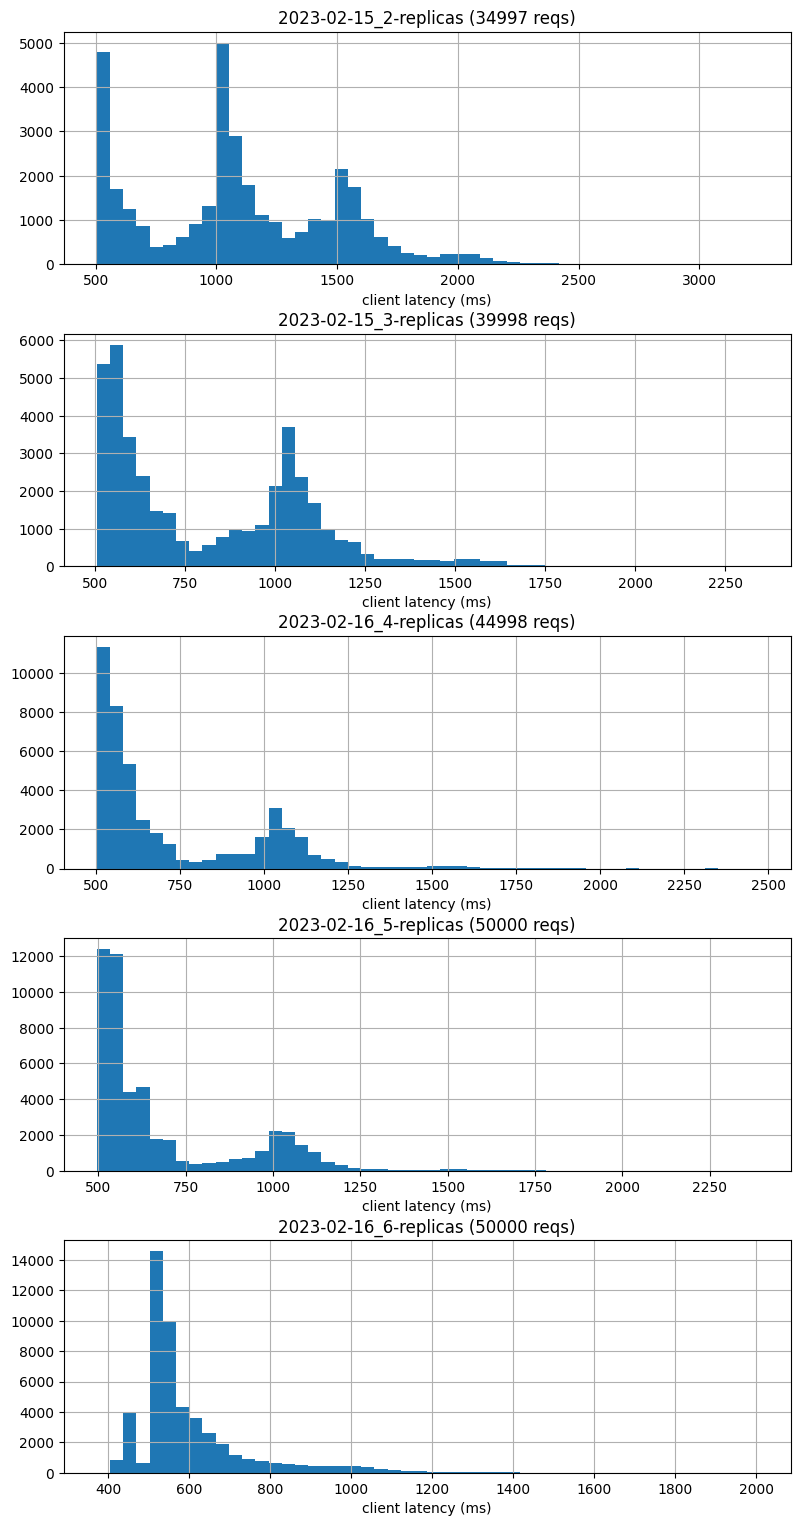

In [29]:
print(util.experiments)
util.compare_client_latency_distributions()

## Experiment Complete - Compare data window between Client and Prometheus

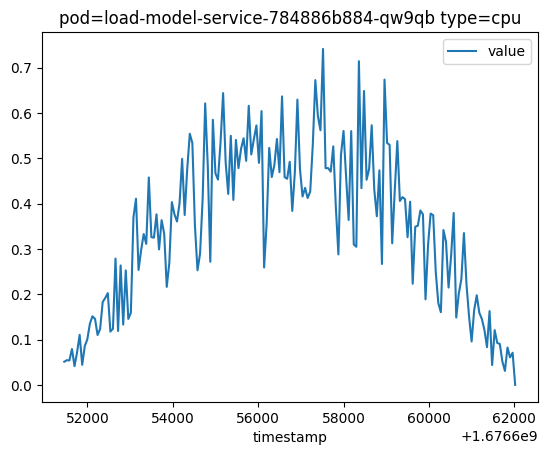

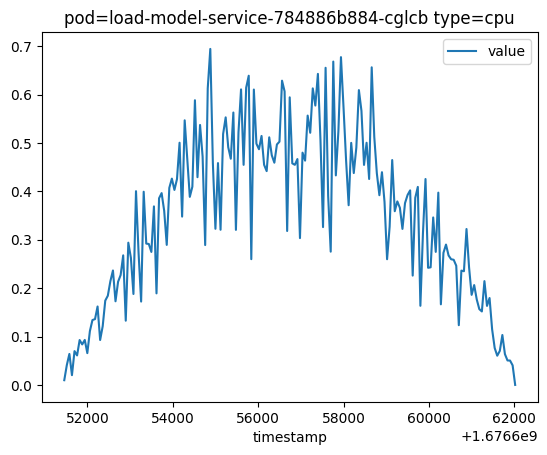

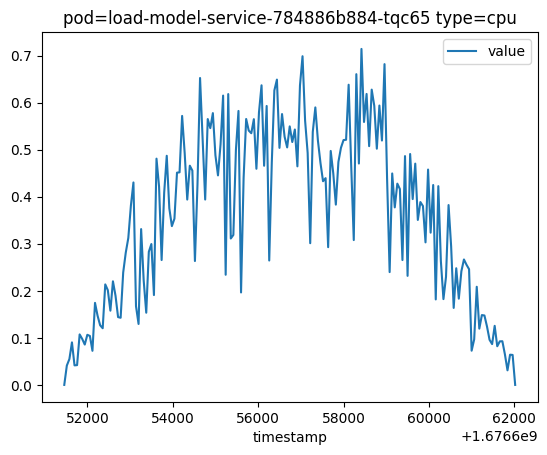

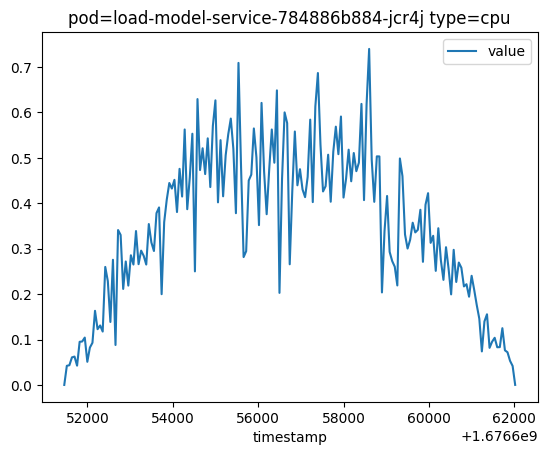

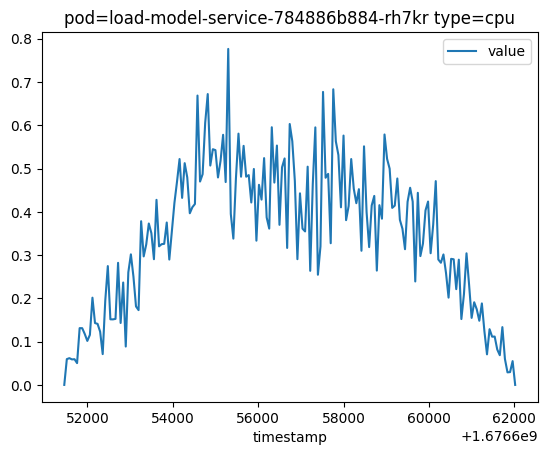

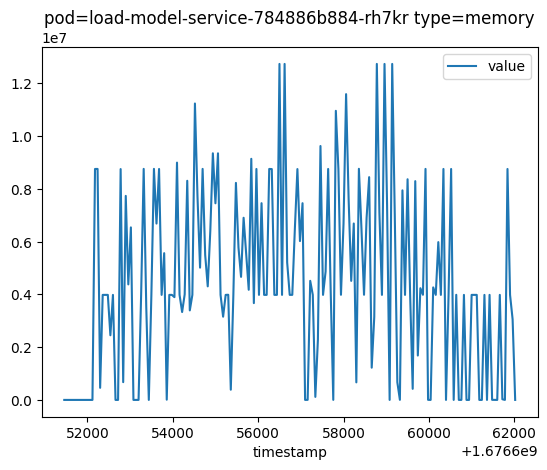

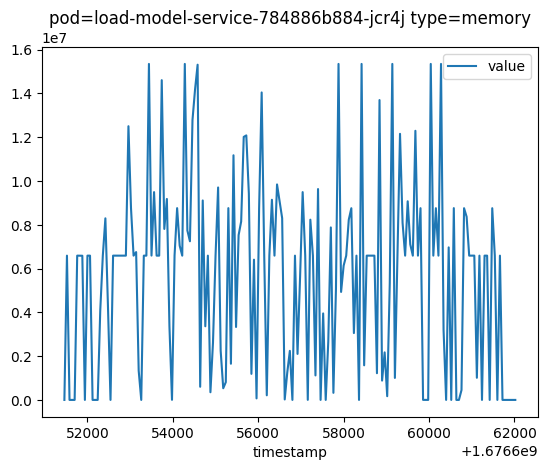

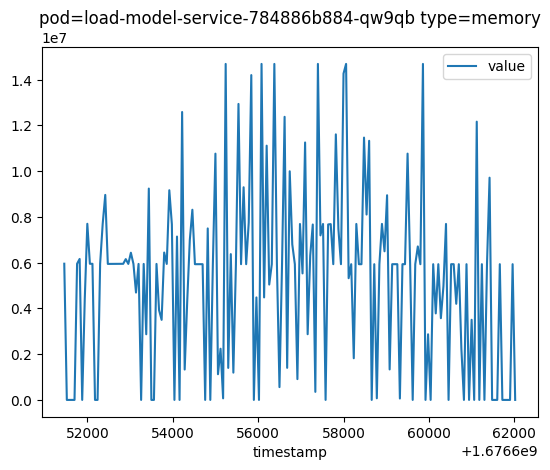

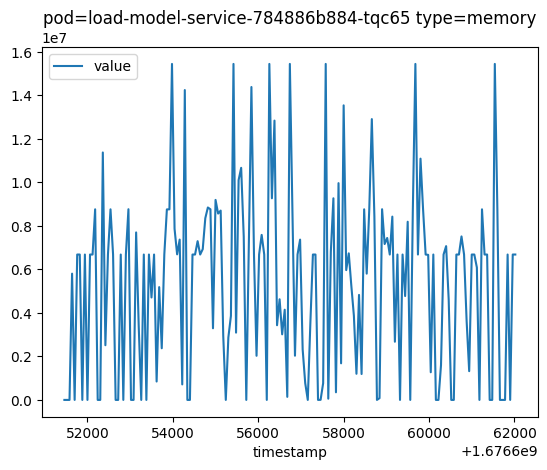

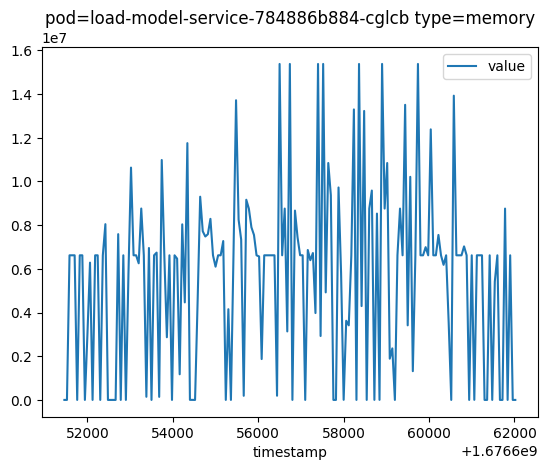

In [30]:
result = util.read_pod_df_list(current_experiment, first_request_time, final_request_time)
util.plot_pod_metrics(result)

### To Do
* correlations between client and server metrics
* what parameters to scan with more tests?
* how long is 10K transactions?

In [ ]:
key = list(dfs_cpu.keys())[1]
print(key)
plt.plot(dfs_cpu[key].value.values, dfs_mem[key].value.values, "r*")